# Naver Movie Review Dataset
#### - Model: Word2vec
#### - POS tagger : Okt
#### - 참고 : 한국어임베딩 교재

## Import

In [14]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. Data Load

In [16]:
# train_data = pd.read_table('matched_review_movieid.txt')
df = pd.read_csv('matched_review_movieid.txt', names=['origin_review'], error_bad_lines=False)

In [17]:
df.head()

,origin_review
0,정말 재미있게 본 훌륭한 드라마였다.␞74379
1,졸잼ㅇㄱㅂ니다. 졸잼␞74379
2,CG가 않좋아서 1점입니다␞74379
3,왜 이 드라마의 가치를 몰라보는가... 스토리도 대사도 일부러 만화적으로 만든걸 모...
4,만화 신불사의 1부를 드라마로 옮겼는데


In [18]:
len(df)

708613

In [19]:
# 데이터셋 전처리 : id와 review 구분
lines = df['origin_review']
test_list = []
review_list = []
id_list = []

for line in lines:
    try:
        tmp = line.split('␞')
        test_list.append(tmp[0])
        tmp[0]
        tmp[1]
    except:
        continue
    review_list.append(tmp[0])
    id_list.append(tmp[1])

In [20]:
data = {'id': id_list, 'review': review_list}
data = pd.DataFrame(data)

In [21]:
data.head()

,id,review
0,74379,정말 재미있게 본 훌륭한 드라마였다.
1,74379,졸잼ㅇㄱㅂ니다. 졸잼
2,74379,CG가 않좋아서 1점입니다
3,74379,왜 이 드라마의 가치를 몰라보는가... 스토리도 대사도 일부러 만화적으로 만든걸 모...
4,74379,진짜 재밌게봤었는데!


In [22]:
len(data)

636178

### 2. Missing value 처리

In [23]:
# 중복제외 리뷰 갯수 : 636178 -> 612619
data['review'].nunique()

612619

In [24]:
data.drop_duplicates(subset=['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print(len(data))

612619


In [25]:
# 한글, 공백 제외한 문자제거
data['review'] = data['review'].str.replace("[^ㄱ-하-ㅣ가힣]"," ")

In [26]:
data.isnull().values.any()

False

In [27]:
data['review'].replace('',np.nan,inplace=True)
print(data.isnull().sum())

id        0
review    1
dtype: int64


In [28]:
data.loc[data.review.isnull()]

,id,review
400568,90343\n샤룩에 대한 애정만으로 만점,NaN


In [29]:
tmp = data.loc[data.review.isnull()]

In [30]:
missing_value = tmp.loc[400568]['id'].split('\n')

In [31]:
print(missing_value)

['90343', '샤룩에 대한 애정만으로 만점']


In [32]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print(len(data))

612618


In [33]:
data.append({'id': missing_value[0], 'review': missing_value[1]}, ignore_index=True)

,id,review
0,74379,정말 재미있게 본 륭 드라마였다
1,74379,졸잼ㅇㄱㅂ니다 졸잼
2,74379,가 않좋아서 점입니다
3,74379,왜 이 드라마의 가치를 몰라보는가 스토리도 대사도 일부러 만 적으로 만든걸 모...
4,74379,진짜 재밌게봤었는데
...,...,...
612614,17762,아련 기억과 께 새겨지는 백의 영상
612615,17762,비장하지만 어리석다
612616,17762,예전의기억 저편에 남아 언제나 주인공의 절규가 들리는 영
612617,17762,마지막 주인공이 차를몰면서 절규하며 따라부르는 바하의 토카타와푸가 죽음


In [34]:
print(data.isnull().sum())

id        0
review    0
dtype: int64


### 3. 데이터 전처리 
- 불용어
- 형태소 분석 : Okt(Twitter)

In [35]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, train_size=0.7)

In [36]:
print(len(train_data))
print(len(test_data))

428832
183786


- 한국어 불용어(Stopwords)

In [37]:
df_stopwords = pd.read_csv('./korean_stopwords.txt', names=['stopword', 'POS', 'rate'], header=None, delimiter='\t')

In [38]:
df_stopwords.head()

,stopword,POS,rate
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [39]:
stopwords = df_stopwords['stopword'].tolist()

In [40]:
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [41]:
okt = Okt()

#### okt.morphs의 옵션
- norm : normalize의 약자로 정규화
- stem : 각 단어에서 어간 추출

In [42]:
# 텍스트를 형태소 단위로 구분 후 어간 추출
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
# 불용어처리 X_train 저장
X_train = []
from tqdm import tqdm
for sentence in tqdm(train_data['review']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

 79%|███████▉  | 339412/428832 [12:08<03:37, 410.47it/s]

In [61]:
# 불용어처리 X_test 저장
X_test = []
for sentence in tqdm(test_data['review']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

100%|██████████| 183786/183786 [07:40<00:00, 399.50it/s]


In [ ]:
train_data[['review']].head()

In [ ]:
print(X_train[:5])

### 4. 모델 설계 : Word2Vec

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(X_train, size=300, window=3, min_count = 5, workers=1)

- 모델 저장

In [ ]:
model.save('word2vec.model')

- 모델 로드

In [ ]:
model = Word2Vec.load('word2vec.model')

In [ ]:
# 워드임베딩 벡터 할당
word_vectors = model.wv

In [ ]:
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

In [ ]:
word_vectors_list[0]

**유사어 확인**

In [ ]:
model.wv.most_similar("감독", topn=15)

In [ ]:
model.wv.most_similar("하정우")

In [ ]:
model.wv.most_similar("노잼")

In [ ]:
model.wv.most_similar("대박")

### 5. 임베딩 결과 시각화
- PCA
- t-SNE

#### 5-1) PCA

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)#300차원 벡터를 2차원으로 축소

In [69]:
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

In [70]:
print(xys[:5])

[[ 1.53504601 -4.97254262]
 [-0.08421865 -0.2988996 ]
 [ 3.11607841 -2.43381019]
 [ 1.70467531  0.43507654]
 [ 2.1378246   1.07495655]]


In [71]:
print(xs[:5])

[ 1.53504601 -0.08421865  3.11607841  1.70467531  2.1378246 ]


In [87]:
print(ys[:5])

[-4.97254262 -0.2988996  -2.43381019  0.43507654  1.07495655]


In [73]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(25,15))
    plt.scatter(xs, ys, marker = 'o')
    for i,v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

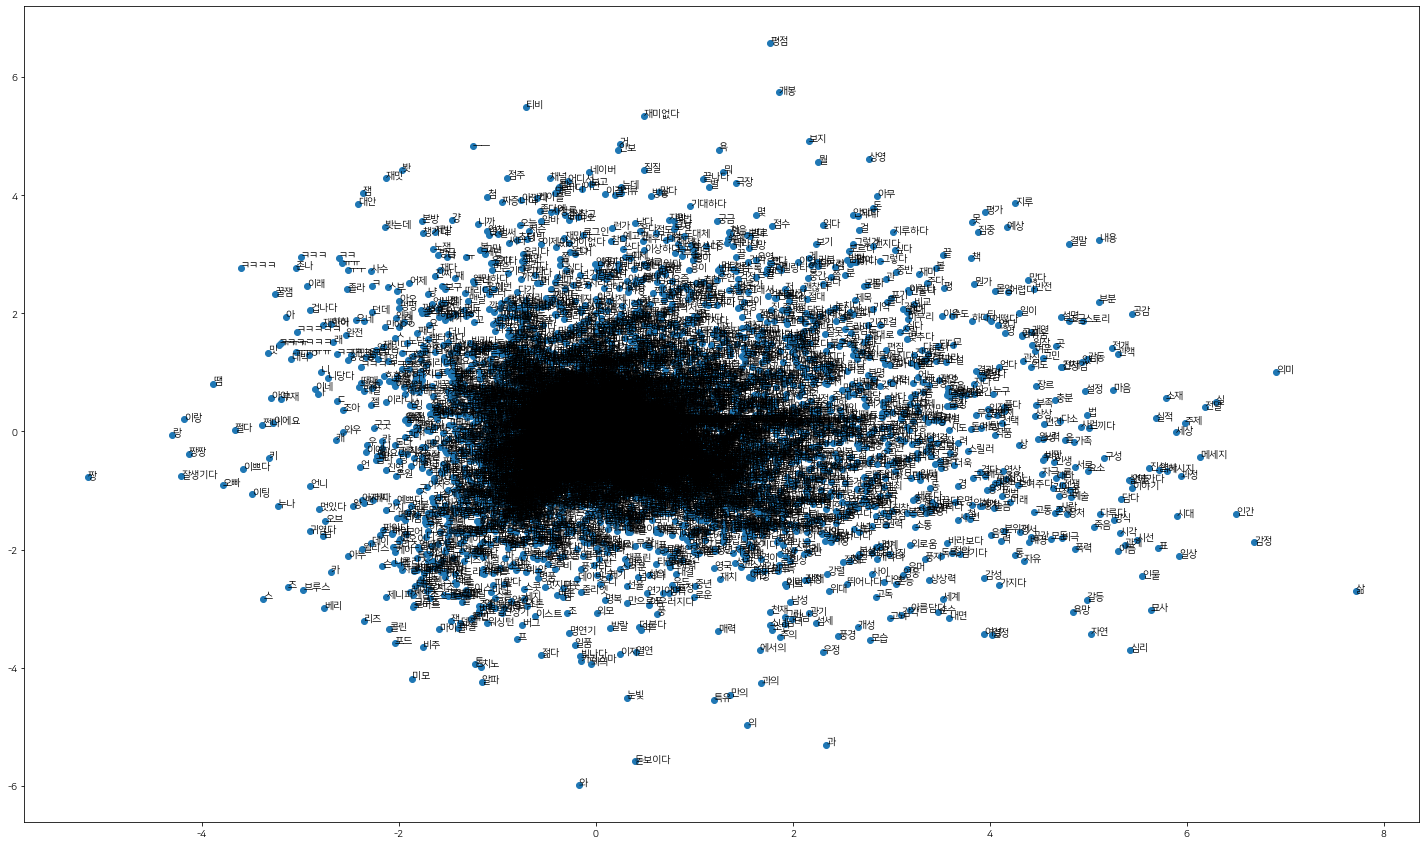

In [96]:
plot_2d_graph(vocabs, xs, ys)

#### 5-2) t-SNE

In [97]:
from sklearn.manifold import TSNE

In [98]:
model2 = TSNE(learning_rate = 100)

In [99]:
transformed = model2.fit_transform(word_vectors_list)

In [100]:
xs2 = transformed[:,0]
ys2 = transformed[:,1]

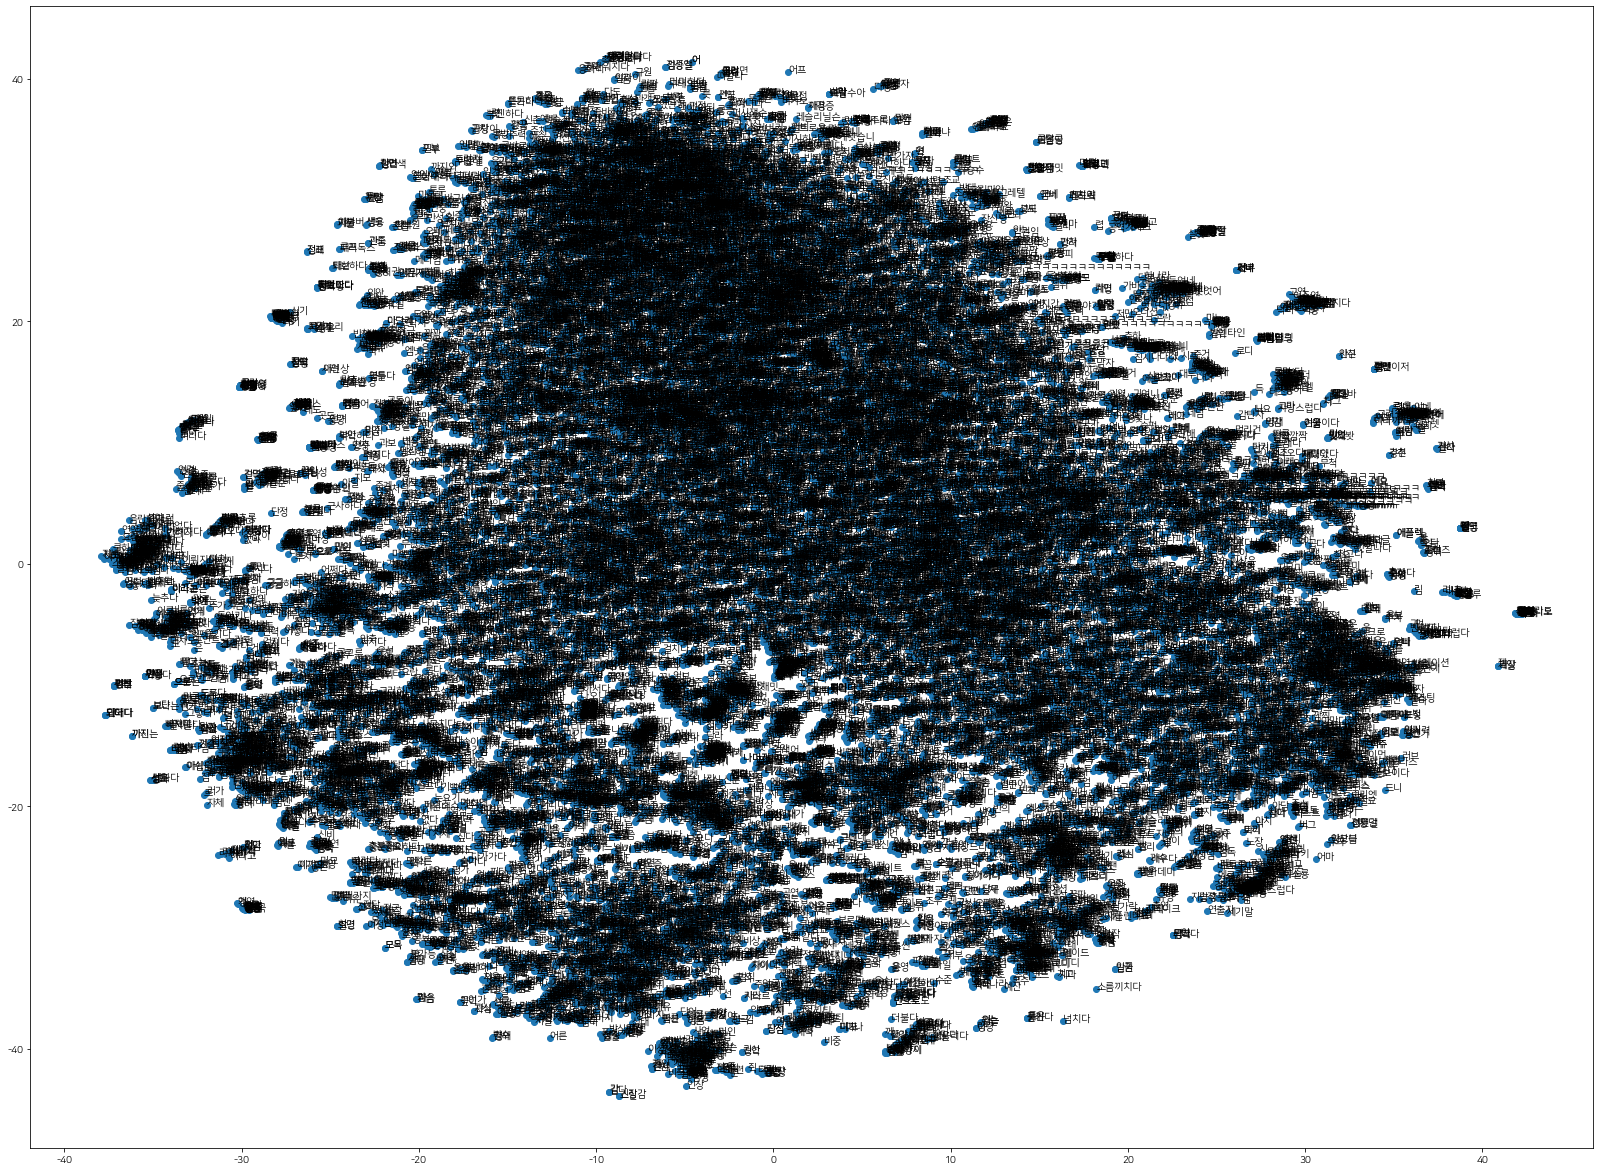

In [101]:
plt.figure(figsize=(28,21))

plt.scatter(xs2,ys2)

for i,v in enumerate(vocabs):
    plt.annotate(v, xy=(xs2[i],ys2[i]))
    
plt.show()

#### 5-3) Embedding Projector

In [109]:
from gensim.models import KeyedVectors  

# 워드임베딩 값을 'naver_w2v'파일로 변환
model.wv.save_word2vec_format('naver_w2v')

**파일 생성**
- naver_w2v_tensor.tsv
- naver_w2v_metadata.tsv

In [110]:
!python -m gensim.scripts.word2vec2tensor --input naver_w2v --output naver_w2v

2021-05-03 21:11:43,245 - word2vec2tensor - INFO - running C:\Users\user\anaconda3\envs\kse_env\lib\site-packages\gensim\scripts\word2vec2tensor.py --input naver_w2v --output naver_w2v
2021-05-03 21:11:43,245 - utils_any2vec - INFO - loading projection weights from naver_w2v
2021-05-03 21:11:47,612 - utils_any2vec - INFO - loaded (20744, 300) matrix from naver_w2v
2021-05-03 21:11:51,092 - word2vec2tensor - INFO - 2D tensor file saved to naver_w2v_tensor.tsv
2021-05-03 21:11:51,092 - word2vec2tensor - INFO - Tensor metadata file saved to naver_w2v_metadata.tsv
2021-05-03 21:11:51,096 - word2vec2tensor - INFO - finished running word2vec2tensor.py


**[Embedding Projector 실행]**

- 링크 : https://projector.tensorflow.org/
- Load: tensor.tsv, metadata.tsv